# 模型训练
本`notebook`是`任庆桦`老师在江苏大学`24fall`专业实践小组作业的模型训练部分。    
本部分实现并训练了三个模型用于`cifar10`数据集的分类：   
1. `alexnet`
2. `mobilenetv3`
3. `shufflenetv2`

## 导入库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader
import random
import string
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 模型定义

### 1. `AlexNet`

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, dropout=0.5):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # 论文中的输出通道数为96，pytorch官方为64
            # nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # 论文中的输出通道数为256，pytorch官方为192
            # nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        # 这一操作是为了保证特征提取后的特征图大小为 6x6，使得网络可以接受224x224以外尺寸的图像
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        # 提取图像特征
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        # 进行图像分类
        x = self.classifier(x)
        return x


In [4]:
model_AlexNet = AlexNet(num_classes=10)
inputs = torch.randn(1, 3, 224, 224)
out = model_AlexNet(inputs)
print(out.shape)

torch.Size([1, 10])


### 2. `Mobilenetv3`

In [5]:
class HardSwish(nn.Module):
    def __init__(self, inplace=True):
        super(HardSwish, self).__init__()
        self.relu6 = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return x * self.relu6(x+3)/6


class ConvBNActivation(nn.Sequential):
    def __init__(self, in_channel, out_channel, kernel_size, stride, groups, activate):
        padding = (kernel_size - 1) // 2
        super(ConvBNActivation, self).__init__(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU6(inplace=True) if activate == 'relu' else HardSwish()
        )


class SqueezeAndExcite(nn.Module):
    def __init__(self, in_channel, out_channel, divide=4):
        super(SqueezeAndExcite, self).__init__()
        mid_channel = in_channel // divide
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.SEblock = nn.Sequential(
            nn.Linear(in_features=in_channel, out_features=mid_channel),
            nn.ReLU6(inplace=True),
            nn.Linear(in_features=mid_channel, out_features=out_channel),
            HardSwish(),
        )

    def forward(self, x):
        b, c, h, w = x.size()
        out = self.pool(x)
        out = torch.flatten(out, start_dim=1)
        out = self.SEblock(out)
        out = out.view(b, c, 1, 1)
        return out * x


class SEInverteBottleneck(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel, kernel_size, use_se, activate, stride):
        super(SEInverteBottleneck, self).__init__()
        self.use_shortcut = stride == 1 and in_channel == out_channel
        self.use_se = use_se

        self.conv = ConvBNActivation(in_channel=in_channel, out_channel=mid_channel, kernel_size=1, stride=1, groups=1, activate=activate)
        self.depth_conv = ConvBNActivation(in_channel=mid_channel, out_channel=mid_channel, kernel_size=kernel_size, stride=stride, groups=mid_channel, activate=activate)
        if self.use_se:
            self.SEblock = SqueezeAndExcite(in_channel=mid_channel, out_channel=mid_channel)

        self.point_conv = ConvBNActivation(in_channel=mid_channel, out_channel=out_channel, kernel_size=1, stride=1, groups=1, activate=activate)

    def forward(self, x):
        out = self.conv(x)
        out = self.depth_conv(out)
        if self.use_se:
            out = self.SEblock(out)
        out = self.point_conv(out)
        if self.use_shortcut:
            return x + out
        return out


class MobileNetV3(nn.Module):
    def __init__(self, num_classes=1000, type='large'):
        super(MobileNetV3, self).__init__()
        self.type = type

        self.first_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            HardSwish(),
        )

        if self.type == 'large':
            self.large_bottleneck = nn.Sequential(
                SEInverteBottleneck(in_channel=16, mid_channel=16, out_channel=16, kernel_size=3, use_se=False, activate='relu', stride=1),
                SEInverteBottleneck(in_channel=16, mid_channel=64, out_channel=24, kernel_size=3, use_se=False, activate='relu', stride=2),
                SEInverteBottleneck(in_channel=24, mid_channel=72, out_channel=24, kernel_size=3, use_se=False, activate='relu', stride=1),
                SEInverteBottleneck(in_channel=24, mid_channel=72, out_channel=40, kernel_size=5, use_se=True, activate='relu', stride=2),
                SEInverteBottleneck(in_channel=40, mid_channel=120, out_channel=40, kernel_size=5, use_se=True, activate='relu', stride=1),
                SEInverteBottleneck(in_channel=40, mid_channel=120, out_channel=40, kernel_size=5, use_se=True, activate='relu', stride=1),
                SEInverteBottleneck(in_channel=40, mid_channel=240, out_channel=80, kernel_size=3, use_se=False, activate='hswish', stride=2),
                    SEInverteBottleneck(in_channel=80, mid_channel=200, out_channel=80, kernel_size=3, use_se=False, activate='hswish', stride=1),
                SEInverteBottleneck(in_channel=80, mid_channel=184, out_channel=80, kernel_size=3, use_se=False, activate='hswish', stride=1),
                SEInverteBottleneck(in_channel=80, mid_channel=184, out_channel=80, kernel_size=3, use_se=False, activate='hswish', stride=1),
                SEInverteBottleneck(in_channel=80, mid_channel=480, out_channel=112, kernel_size=3, use_se=True, activate='hswish', stride=1),
                SEInverteBottleneck(in_channel=112, mid_channel=672, out_channel=112, kernel_size=3, use_se=True, activate='hswish', stride=1),
                SEInverteBottleneck(in_channel=112, mid_channel=672, out_channel=160, kernel_size=5, use_se=True, activate='hswish', stride=2),
                SEInverteBottleneck(in_channel=160, mid_channel=960, out_channel=160, kernel_size=5, use_se=True, activate='hswish', stride=1),
                SEInverteBottleneck(in_channel=160, mid_channel=960, out_channel=160, kernel_size=5, use_se=True, activate='hswish', stride=1),
            )
            self.large_last_stage = nn.Sequential(
                nn.Conv2d(in_channels=160, out_channels=960, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(960),
                HardSwish(),
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Conv2d(in_channels=960, out_channels=1280, kernel_size=1, stride=1, bias=False),
                HardSwish(),
            )
        else:
            self.small_bottleneck = nn.Sequential(
                SEInverteBottleneck(in_channel=16, mid_channel=16, out_channel=16, kernel_size=3, use_se=True, activate='relu', stride=2),
                SEInverteBottleneck(in_channel=16, mid_channel=72, out_channel=24, kernel_size=3, use_se=False, activate='relu', stride=2),
                SEInverteBottleneck(in_channel=24, mid_channel=88, out_channel=24, kernel_size=3, use_se=False, activate='relu', stride=1),
                SEInverteBottleneck(in_channel=24, mid_channel=96, out_channel=40, kernel_size=5, use_se=True, activate='hswish', stride=2),
                SEInverteBottleneck(in_channel=40, mid_channel=240, out_channel=40, kernel_size=5, use_se=True, activate='hswish', stride=1),
                SEInverteBottleneck(in_channel=40, mid_channel=240, out_channel=40, kernel_size=5, use_se=True, activate='hswish', stride=1),
                SEInverteBottleneck(in_channel=40, mid_channel=120, out_channel=48, kernel_size=5, use_se=True, activate='hswish', stride=1),
                SEInverteBottleneck(in_channel=48, mid_channel=144, out_channel=48, kernel_size=5, use_se=True, activate='hswish', stride=1),
                SEInverteBottleneck(in_channel=48, mid_channel=288, out_channel=96, kernel_size=5, use_se=True, activate='hswish', stride=2),
                SEInverteBottleneck(in_channel=96, mid_channel=576, out_channel=96, kernel_size=5, use_se=True, activate='hswish', stride=1),
                SEInverteBottleneck(in_channel=96, mid_channel=576, out_channel=96, kernel_size=5, use_se=True, activate='hswish', stride=1),
            )
            self.small_last_stage = nn.Sequential(
                nn.Conv2d(in_channels=96, out_channels=576, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(576),
                HardSwish(),
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Conv2d(in_channels=576, out_channels=1280, kernel_size=1, stride=1, bias=False),
                HardSwish(),
            )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1280, out_features=num_classes),
        )

        # weight init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.first_conv(x)
        if self.type == 'large':
            x = self.large_bottleneck(x)
            x = self.large_last_stage(x)
        else:
            x = self.small_bottleneck(x)
            x = self.small_last_stage(x)

        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x


In [6]:
inputs = torch.randn(1, 3, 224, 224)
model_Mobilenetv3 = MobileNetV3(num_classes=10)
out = model_Mobilenetv3(inputs)
print(out.shape)

torch.Size([1, 10])


### 3. `Shufflenetv2`

In [7]:
class ConvBNReLu(nn.Sequential):
    def __init__(self, in_channel, out_channel, kernel_size, stride, groups):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLu, self).__init__(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride,
                      padding=padding, groups=groups),
            nn.BatchNorm2d(out_channel),
            nn.ReLU6(inplace=True),
        )


class ConvBN(nn.Sequential):
    def __init__(self, in_channel, out_channel, kernel_size, stride, groups):
        padding = (kernel_size - 1) // 2
        super(ConvBN, self).__init__(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride,
                      padding=padding, groups=groups),
            nn.BatchNorm2d(out_channel),
        )


class HalfSplit(nn.Module):
    """
    实现channel split
    """
    def __init__(self, dim=0, first_half=True):
        super(HalfSplit, self).__init__()
        self.first_half = first_half
        self.dim = dim

    def forward(self, x):
        splits = torch.chunk(x, 2, dim=self.dim)
        return splits[0] if self.first_half else splits[1]


class ChannelShuffle(nn.Module):
    def __init__(self, groups):
        super(ChannelShuffle, self).__init__()
        self.groups = groups

    def forward(self, x):
        # Channel shuffle: [N,C,H,W] -> [N,g,C/g,H,W] -> [N,C/g,g,H,w] -> [N,C,H,W]
        batch_size, num_channels, height, width = x.size()
        channels_per_group = num_channels // self.groups
        x = x.view(batch_size, self.groups, channels_per_group, height, width)
        x = torch.transpose(x, dim0=1, dim1=2).contiguous()
        x = x.view(batch_size, -1, height, width)
        return x


class ShuffleNetUnits(nn.Module):
    def __init__(self, in_channel, out_channel, stride, groups):
        super(ShuffleNetUnits, self).__init__()
        self.stride = stride
        if self.stride > 1:
            mid_channel = out_channel - in_channel
        else:
            mid_channel = out_channel // 2
            in_channel = mid_channel
            self.first_split = HalfSplit(dim=1, first_half=True)
            self.second_split = HalfSplit(dim=1, first_half=False)

        # 论文中Fig.3.(d) 中的右半部分
        self.bottleneck = nn.Sequential(
            # 1x1 Conv
            ConvBNReLu(in_channel=in_channel, out_channel=mid_channel, kernel_size=1, stride=1, groups=1),
            # 3x3 DWConv
            ConvBN(in_channel=mid_channel, out_channel=mid_channel, kernel_size=3, stride=stride, groups=mid_channel),
            # 1x1 Conv
            ConvBNReLu(in_channel=mid_channel, out_channel=mid_channel, kernel_size=1, stride=1, groups=1),
        )

        if self.stride > 1:
            # 论文中Fig.3.(d) 中的左半部分
            self.shortcut = nn.Sequential(
                # 3x3 DWConv
                ConvBN(in_channel=in_channel, out_channel=in_channel, kernel_size=3, stride=stride, groups=in_channel),
                # 1x1 Conv
                ConvBNReLu(in_channel=in_channel, out_channel=in_channel, kernel_size=1, stride=1, groups=1),
            )

        self.channel_shuffle = ChannelShuffle(groups=groups)

    def forward(self, x):
        if self.stride > 1:
            x1 = self.bottleneck(x)
            x2 = self.shortcut(x)
        else:
            # channel split
            x1 = self.first_split(x)
            x2 = self.second_split(x)
            x1 = self.bottleneck(x1)
        out = torch.cat([x1, x2], dim=1)
        out = self.channel_shuffle(out)
        return out


class ShuffleNetV2(nn.Module):
    def __init__(self, planes, layers, groups, num_classes=1000):
        super(ShuffleNetV2, self).__init__()
        self.groups = groups

        self.stage1 = nn.Sequential(
            ConvBNReLu(in_channel=3, out_channel=24, kernel_size=3, stride=2, groups=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.stage2 = self._make_layers(in_channel=24, out_channel=planes[0], block_num=layers[0], is_stage2=True)
        self.stage3 = self._make_layers(in_channel=planes[0], out_channel=planes[1], block_num=layers[1],
                                        is_stage2=False)
        self.stage4 = self._make_layers(in_channel=planes[1], out_channel=planes[2], block_num=layers[2],
                                        is_stage2=False)

        self.conv5 = ConvBNReLu(in_channel=planes[2], out_channel=planes[3], kernel_size=1, stride=1, groups=1)
        self.globalpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=planes[3], out_features=num_classes)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.Linear):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layers(self, in_channel, out_channel, block_num, is_stage2):
        layers = []
        layers.append(ShuffleNetUnits(in_channel=in_channel, out_channel=out_channel, stride=2,
                                      groups=1 if is_stage2 else self.groups))
        for _ in range(1, block_num):
            layers.append(
                ShuffleNetUnits(in_channel=out_channel, out_channel=out_channel, stride=1, groups=self.groups))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.conv5(x)
        x = self.globalpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x


def shufflenet_v2_x1_5(**kwargs):
    planes = [176, 352, 704, 1024]
    layers = [4, 8, 4]
    model = ShuffleNetV2(planes=planes, layers=layers, groups=1, **kwargs)
    return model



In [8]:
inputs = torch.randn(1, 3, 224, 224)
model_shufflenet = shufflenet_v2_x1_5(num_classes=10)
out = model_shufflenet(inputs)
print(out.shape)

torch.Size([1, 10])


## 绘图函数

`plot_model_losses`函数可以将多个模型的loss训练过程绘画在一张图，便于展示结果。

In [9]:
def plot_model_losses(train_losses, val_losses, names):
    nets = len(names)  
    cols = 3 
    
    rows = (nets + cols - 1) // cols  # 计算行数，确保布局合理
    
    # 创建一个符合网格布局的图形
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
    
    # if rows == 1:
    #     axes = [axes]  # 如果只有一行，确保 axes 是一个列表
    
    for i in range(nets):
        row = i // cols  
        col = i % cols   
        ax = axes[row][col] if rows > 1 else axes[col]
        
        # 确保 train_losses[i] 和 val_losses[i] 是一维数组或列表
        ax.plot(train_losses[i], label='Train Loss')
        ax.plot(val_losses[i], label='Test Loss')
        ax.set_title(f'Model {names[i]} Losses')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    plt.tight_layout()
    
    # 关闭空的子图
    for j in range(i + 1, rows * cols):
        row = j // cols
        col = j % cols
        ax = axes[row][col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.show()


`plot_val_acc`函数可以接受模型的验证准确率、模型名称、绘图样式，然后将所有模型的验证集准确率进行对比

In [10]:
def plot_val_acc(val_acc_list, model_names, styles=None, figsize=(15, 5), title='Model Accuracy', ylabel='Accuracy', xlabel='Epoch', ylim=(0.98, 1)):

    if styles is None:
        styles = [':', '-.', '--', '-', ':', '-.', '--', '-'] * (len(val_acc_list) // 4 + 1)

    plt.figure(figsize=figsize)
    for i, val_acc in enumerate(val_acc_list):
        plt.plot(val_acc, linestyle=styles[i % len(styles)], label=model_names[i])

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(loc='upper left')
    axes = plt.gca()
    axes.set_ylim(ylim)
    plt.show()


## 模型训练函数

In [11]:
def train_model(model, train_loader, test_loader, epochs=20, device="cpu", model_name=''):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []
    
    model.to(device)
    
    while True:
        folder_path = "./weight_" + model_name + '_' + ''.join(random.choices(string.ascii_lowercase + string.digits, k=10))
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            break

    print(f"weights are saved to {folder_path} ")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss.append(running_loss / len(test_loader))
        val_acc.append(correct / total)

        # 保存模型
        model_file = os.path.join(folder_path, f"epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_file)
        print(f"Saved model at epoch {epoch+1} to {model_file}")
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.4f}")

    return train_loss, train_acc, val_loss, val_acc

## 数据集导入

In [12]:
# 强力的数据增强组合，只应用于训练集
train_transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.RandomHorizontalFlip(),  # 随机水平翻转，保持不变
    transforms.RandomRotation(10),  # 随机旋转角度减小，从15度减少到5度
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),  # 随机裁剪，
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # 随机调整颜色幅度减小
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化
])

# 仅进行标准化的转换，应用于测试集
test_transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化
])

# 加载CIFAR-10数据集
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 49241583.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
def plotsample(data):
    fig, axs = plt.subplots(1,5,figsize=(10,10)) #建立子图
    for i in range(5):
        num = random.randint(0,len(data)-1) #首先选取随机数，随机选取五次
        #抽取数据中对应的图像对象，make_grid函数可将任意格式的图像的通道数升为3，而不改变图像原始的数据
        #而展示图像用的imshow函数最常见的输入格式也是3通道
        npimg = torchvision.utils.make_grid(data[num][0]).numpy()
        nplabel = data[num][1] #提取标签
        #将图像由(3, weight, height)转化为(weight, height, 3)，并放入imshow函数中读取
        axs[i].imshow(np.transpose(npimg, (1, 2, 0))) 
        axs[i].set_title(nplabel) #给每个子图加上标签
        axs[i].axis("off") #消除每个子图的坐标轴

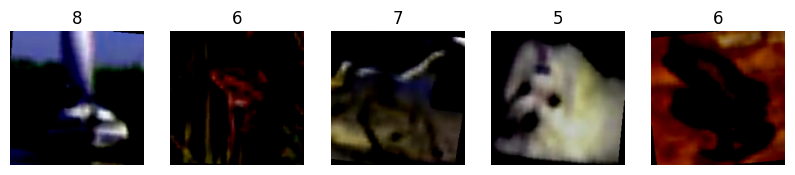

In [14]:
plotsample(train_dataset)

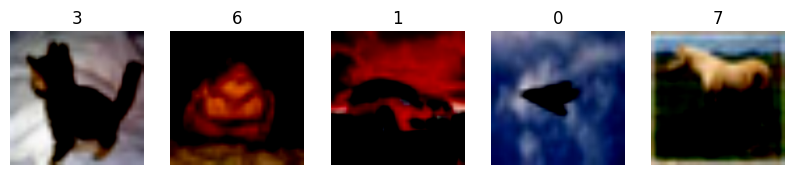

In [15]:
plotsample(test_dataset)

## 训练

In [16]:
model_name_list = ['alex', 'Mobilenetv3', 'shufflenet']

train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

In [17]:
train_loss, train_acc, val_loss, val_acc = train_model(model=model_AlexNet, train_loader=train_loader, test_loader=test_loader, epochs=15, device=device, model_name=model_name_list[0])

train_loss_list.append(train_loss)
train_acc_list.append(train_acc)
val_loss_list.append(val_loss)
val_acc_list.append(val_acc)

weights are saved to ./weight_alex_zdujejk25c 
Saved model at epoch 1 to ./weight_alex_zdujejk25c/epoch_1.pth
Epoch 1/15, Train Loss: 1.8127, Train Accuracy: 0.3208, Validation Loss: 1.5210, Validation Accuracy: 0.4327
Saved model at epoch 2 to ./weight_alex_zdujejk25c/epoch_2.pth
Epoch 2/15, Train Loss: 1.5238, Train Accuracy: 0.4433, Validation Loss: 1.3262, Validation Accuracy: 0.5190
Saved model at epoch 3 to ./weight_alex_zdujejk25c/epoch_3.pth
Epoch 3/15, Train Loss: 1.4113, Train Accuracy: 0.4925, Validation Loss: 1.2323, Validation Accuracy: 0.5522
Saved model at epoch 4 to ./weight_alex_zdujejk25c/epoch_4.pth
Epoch 4/15, Train Loss: 1.3306, Train Accuracy: 0.5251, Validation Loss: 1.1336, Validation Accuracy: 0.6066
Saved model at epoch 5 to ./weight_alex_zdujejk25c/epoch_5.pth
Epoch 5/15, Train Loss: 1.2715, Train Accuracy: 0.5472, Validation Loss: 1.1187, Validation Accuracy: 0.6047
Saved model at epoch 6 to ./weight_alex_zdujejk25c/epoch_6.pth
Epoch 6/15, Train Loss: 1.2211

In [18]:
train_loss, train_acc, val_loss, val_acc = train_model(model=model_Mobilenetv3, train_loader=train_loader, test_loader=test_loader, epochs=15, device=device, model_name=model_name_list[1])

train_loss_list.append(train_loss)
train_acc_list.append(train_acc)
val_loss_list.append(val_loss)
val_acc_list.append(val_acc)

weights are saved to ./weight_Mobilenetv3_2qxxfmfpu8 
Saved model at epoch 1 to ./weight_Mobilenetv3_2qxxfmfpu8/epoch_1.pth
Epoch 1/15, Train Loss: 1.7753, Train Accuracy: 0.3233, Validation Loss: 1.3833, Validation Accuracy: 0.4876
Saved model at epoch 2 to ./weight_Mobilenetv3_2qxxfmfpu8/epoch_2.pth
Epoch 2/15, Train Loss: 1.3119, Train Accuracy: 0.5239, Validation Loss: 1.1854, Validation Accuracy: 0.5834
Saved model at epoch 3 to ./weight_Mobilenetv3_2qxxfmfpu8/epoch_3.pth
Epoch 3/15, Train Loss: 1.1775, Train Accuracy: 0.5795, Validation Loss: 1.0460, Validation Accuracy: 0.6235
Saved model at epoch 4 to ./weight_Mobilenetv3_2qxxfmfpu8/epoch_4.pth
Epoch 4/15, Train Loss: 0.9733, Train Accuracy: 0.6572, Validation Loss: 0.8541, Validation Accuracy: 0.6969
Saved model at epoch 5 to ./weight_Mobilenetv3_2qxxfmfpu8/epoch_5.pth
Epoch 5/15, Train Loss: 0.8226, Train Accuracy: 0.7094, Validation Loss: 0.7359, Validation Accuracy: 0.7421
Saved model at epoch 6 to ./weight_Mobilenetv3_2qxx

In [19]:
train_loss, train_acc, val_loss, val_acc = train_model(model=model_shufflenet, train_loader=train_loader, test_loader=test_loader, epochs=15, device=device, model_name=model_name_list[2])

train_loss_list.append(train_loss)
train_acc_list.append(train_acc)
val_loss_list.append(val_loss)
val_acc_list.append(val_acc)

weights are saved to ./weight_shufflenet_t5vlyirho1 
Saved model at epoch 1 to ./weight_shufflenet_t5vlyirho1/epoch_1.pth
Epoch 1/15, Train Loss: 1.5828, Train Accuracy: 0.4105, Validation Loss: 1.2502, Validation Accuracy: 0.5494
Saved model at epoch 2 to ./weight_shufflenet_t5vlyirho1/epoch_2.pth
Epoch 2/15, Train Loss: 1.1423, Train Accuracy: 0.5922, Validation Loss: 0.9566, Validation Accuracy: 0.6582
Saved model at epoch 3 to ./weight_shufflenet_t5vlyirho1/epoch_3.pth
Epoch 3/15, Train Loss: 0.9214, Train Accuracy: 0.6751, Validation Loss: 0.8215, Validation Accuracy: 0.7086
Saved model at epoch 4 to ./weight_shufflenet_t5vlyirho1/epoch_4.pth
Epoch 4/15, Train Loss: 0.7834, Train Accuracy: 0.7252, Validation Loss: 0.7034, Validation Accuracy: 0.7578
Saved model at epoch 5 to ./weight_shufflenet_t5vlyirho1/epoch_5.pth
Epoch 5/15, Train Loss: 0.6896, Train Accuracy: 0.7607, Validation Loss: 0.6419, Validation Accuracy: 0.7778
Saved model at epoch 6 to ./weight_shufflenet_t5vlyirho1/

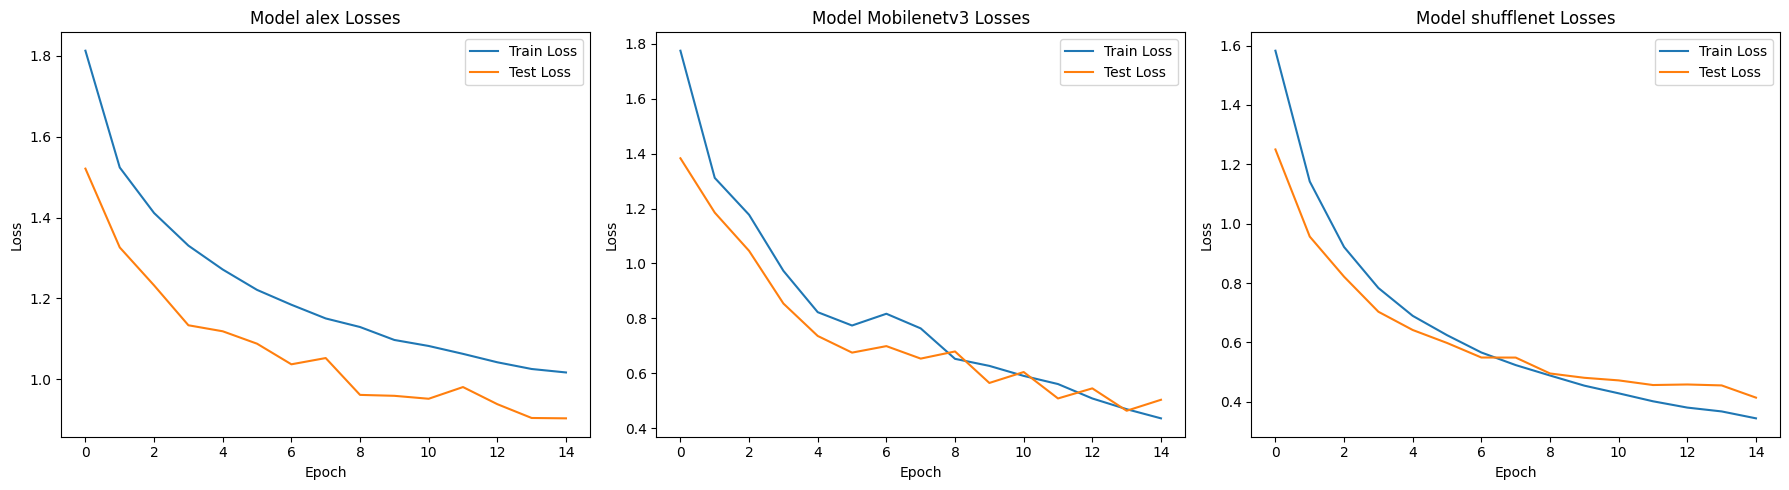

In [20]:
plot_model_losses(train_loss_list, val_loss_list, model_name_list)

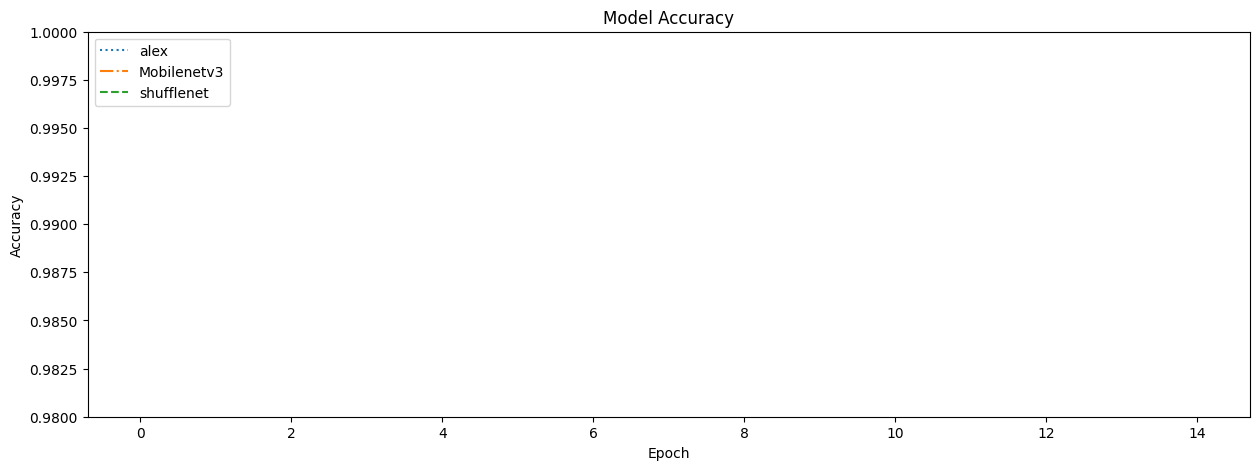

In [21]:
plot_val_acc(val_acc_list, model_name_list, styles=None, figsize=(15, 5), title='Model Accuracy', ylabel='Accuracy', xlabel='Epoch', ylim=(0.98, 1))

In [ ]:
plot_val_acc(val_acc_list, model_name_list, styles=None, figsize=(15, 5), title='Model Accuracy', ylabel='Accuracy', xlabel='Epoch', ylim=(0.3, 1))